In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as Data

import numpy as np
import pandas as pd
import math
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class Model(nn.Module):
    
    def __init__(self, input_size, seq_len):
        
        super(Model, self).__init__()
        
        self.hidden_layer_size = 150
        self.num_layers = 2
        self.input_size = input_size
        self.output_size = 1
        self.seq_len = seq_len

        self.lstm = nn.LSTM(input_size = self.input_size,
                            hidden_size = self.hidden_layer_size,
                            num_layers = self.num_layers,
                            batch_first = True, 
                            dropout = 0.2)

        self.linear = nn.Linear(self.hidden_layer_size * self.seq_len,
                                self.output_size)
        



    def forward(self, x):
        
        batch_size = x.size(0)
        seq_len = self.seq_len
        
        # Initializing the hidden state for first input
        hidden = self.init_hidden(batch_size)
        
        lstm_out, hidden = self.lstm(x, hidden)
                                
        x =  lstm_out.contiguous().view(batch_size,-1)

        return self.linear(x)
    
    
    def init_hidden(self, batch_size):
    
        
        hidden_state = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size)
        cell_state = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size)
        
        hidden = (hidden_state, cell_state)
                
        return hidden



In [3]:
def parse(x):
    return datetime.strptime(x, '%Y-%m-%d')

df = pd.read_csv('TSLA.csv',  parse_dates = True, index_col=0, date_parser=parse)
df.columns = ['Open', 'High', 'Low', 'Close', 'Adj_close', 'Volume']
df.index.name = 'Date'

In [4]:
df.head(5)

,Open,High,Low,Close,Adj_close,Volume
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2416 entries, 2010-06-29 to 2020-02-03
Data columns (total 6 columns):
Open         2416 non-null float64
High         2416 non-null float64
Low          2416 non-null float64
Close        2416 non-null float64
Adj_close    2416 non-null float64
Volume       2416 non-null int64
dtypes: float64(5), int64(1)
memory usage: 132.1 KB


In [6]:
df.describe()

,Open,High,Low,Close,Adj_close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035003,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


In [7]:
print(np.var(df.Close - df.Adj_close))

0.0


In [8]:
df.drop(['Adj_close'], inplace = True, axis = 1)
c_names = [name for name in df.columns]

In [9]:
def split_sequences(dataset, timesteps):
    
    X, y = [],[]
    
    for i in range(timesteps, dataset.shape[0]):
        
        X.append(dataset[i-timesteps:i, :])
        y.append(dataset[i, -1])
        
    
    X, y = np.array(X), np.array(y)
    
    return X, y


In [10]:
dataset = df.loc[:,['High', 'Low', 'Close', 'Volume', 'Open']].values 

num_features = 5

dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)

In [11]:
n_timesteps = 21 # this is number of timesteps, 21 prior days data will be used.

x, y = split_sequences(dataset_scaled, n_timesteps)
print(x.shape)
print(y.shape)

(2395, 21, 5)
(2395,)


In [12]:
train_size = 2000
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [18]:
net = Model(input_size=5, seq_len=n_timesteps) # define the network
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)  # lr is learning rate
loss_func = torch.nn.MSELoss()  # mean squared loss

print(net)

Model(
  (lstm): LSTM(5, 150, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=3150, out_features=1, bias=True)
)


In [19]:
EPOCH = 50
batch_size = 32

pred_data = {}
train_loss = []
test_loss= []


for epoch in range(1, EPOCH):
    
    
    for b in range(0, len(trainX), batch_size):
        
        inpt = trainX[b: b+batch_size, :, :]
        target = trainY[b: b+batch_size]
            
        prediction = net(inpt)
        loss = loss_func(prediction.view(-1), target)
    
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        
    y_predict = net(testX)
    y_predict = y_predict.data.numpy()
    
    net.eval()
    y_predict = net(testX)
        
    pred_data[epoch] = y_predict
    train_loss.append(loss.data.numpy())
    test_loss.append(loss_func(y_predict.view(-1), testY))


    if epoch % 10 == 0:
    
        print('step %s, loss %s' %(epoch, loss.data.numpy()))


    

step 10, loss 0.0008540626
step 20, loss 0.0034107212
step 30, loss 0.0023126078
step 40, loss 0.0022179664


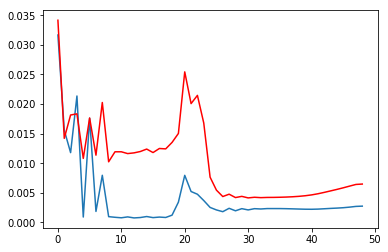

In [20]:
plt.plot(train_loss)
plt.plot(test_loss, color='red')

Test set RMSE: 61.90


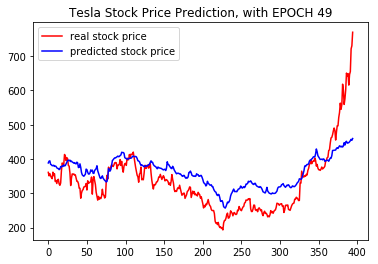

In [22]:
import math

epoch = 49
predicted_price = pred_data[epoch].data.numpy()/scaler.scale_[0]
real_price= dataY[train_size:len(y)].data.numpy()/scaler.scale_[0]
    
rmse = math.sqrt(mean_squared_error(real_price, predicted_price))
print('Test set RMSE: %.2f' % rmse)

plt.plot(real_price, color='red', label='real stock price')
plt.plot(predicted_price, color='blue', label='predicted stock price')
plt.title('Tesla Stock Price Prediction, with EPOCH %s' %epoch)
plt.legend()
plt.show()

In [38]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32

trainloader = DataLoader(TensorDataset(trainX, trainY), batch_size=batch_size, shuffle=True)
testloader = DataLoader(TensorDataset(testX, testY), batch_size=batch_size, shuffle=False)

dataloaders = {
    "train": trainloader,
    "validation": testloader
}

In [39]:
model = Model(input_size=5, seq_len=n_timesteps) # define the network
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # lr is learning rate
loss_func = torch.nn.MSELoss()  # mean squared loss
num_epochs = 100

print(model)

Model(
  (lstm): LSTM(5, 150, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=3150, out_features=1, bias=True)
)


In [40]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

logs = {}
logs['log loss'] = []
logs['val_log loss'] = []



for epoch in range(num_epochs):
    
    model = model.to(device)
    
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        count = 0

        for inputs, labels in dataloaders[phase]:                
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            if len(inputs) != batch_size:
                continue
 
            outputs = model(inputs)
            loss = loss_func(outputs, labels)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            count += 1

        epoch_loss = running_loss / count
            
        prefix = ''
        if phase == 'validation':
            prefix = 'val_'

        logs[prefix + 'log loss'].append(epoch_loss)
        
        print('%s, step %s, loss %s' %(phase, epoch, epoch_loss))

train, step 0, loss 0.09157599001041343
validation, step 0, loss 0.02289699321651521
train, step 1, loss 0.03010111878956518
validation, step 1, loss 0.04540014371741563
train, step 2, loss 0.031418155758611614
validation, step 2, loss 0.03810293708617488
train, step 3, loss 0.02957908247387217
validation, step 3, loss 0.07378085004165769
train, step 4, loss 0.02973855839621636
validation, step 4, loss 0.05310806259512901
train, step 5, loss 0.029500071199670914
validation, step 5, loss 0.051769225780541696
train, step 6, loss 0.030763280758213614
validation, step 6, loss 0.04214317270088941
train, step 7, loss 0.030346225105947065
validation, step 7, loss 0.03965119687685122
train, step 8, loss 0.029602918173036268
validation, step 8, loss 0.05082954574997226
train, step 9, loss 0.029519344619925943
validation, step 9, loss 0.03679019049741328
train, step 10, loss 0.02982353983867553
validation, step 10, loss 0.03684681502636522
train, step 11, loss 0.029496963706708724
validation, st

train, step 94, loss 0.02919636101972672
validation, step 94, loss 0.05749160532529155
train, step 95, loss 0.029106730805529703
validation, step 95, loss 0.044931055628694594
train, step 96, loss 0.029141022943921627
validation, step 96, loss 0.045286190851281084
train, step 97, loss 0.029070022485909924
validation, step 97, loss 0.0483714845807602
train, step 98, loss 0.02921353070245635
validation, step 98, loss 0.04826771677471697
train, step 99, loss 0.029220404373782295
validation, step 99, loss 0.0470559427049011


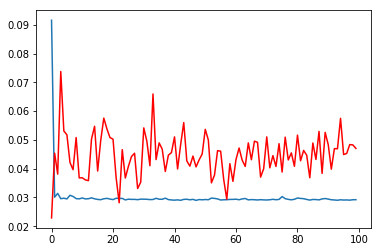

In [41]:
plt.plot(logs['log loss'])
plt.plot(logs['val_log loss'], color='red')